In [1]:
!pip install yfinance dtaidistance statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf
from dtaidistance import dtw
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

#1 Data load and visualization

In [5]:
print("downloading stock data..")
tickers = ['AAPL','MSFT']
data = yf.download(tickers, start='2022-01-01', end='2024-12-01')['Close']
data = data.dropna()

# claculate returns for better stationnarity
returns = data.pct_change().dropna()*100 # convert to percentage
prices =data.copy()

print(f"Data shape: {data.shape}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Total observations: {len(data)}")

[*********************100%***********************]  2 of 2 completed

downloading stock data..
Data shape: (732, 2)
Date range: 2022-01-03 to 2024-11-29
Total observations: 732


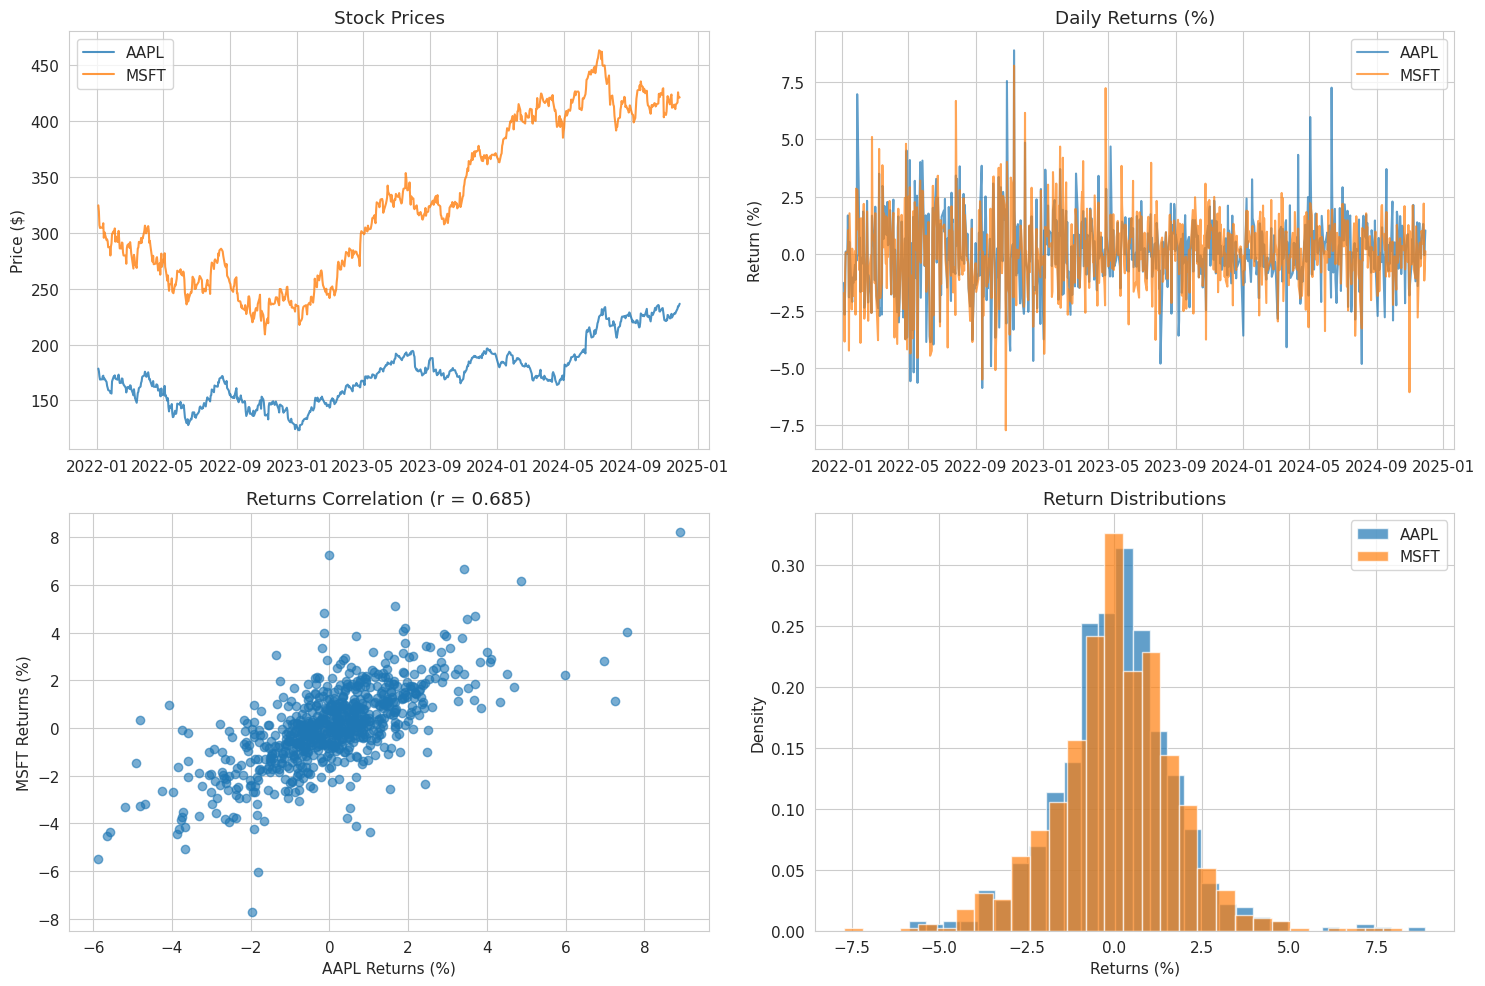

In [6]:
#Basic visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot prices
axes[0,0].plot(prices.index, prices['AAPL'], label='AAPL', alpha=0.8)
axes[0,0].plot(prices.index, prices['MSFT'], label='MSFT', alpha=0.8)
axes[0,0].set_title('Stock Prices')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].legend()

# Plot returns
axes[0,1].plot(returns.index, returns['AAPL'], label='AAPL', alpha=0.7)
axes[0,1].plot(returns.index, returns['MSFT'], label='MSFT', alpha=0.7)
axes[0,1].set_title('Daily Returns (%)')
axes[0,1].set_ylabel('Return (%)')
axes[0,1].legend()

# Correlation plot
axes[1,0].scatter(returns['AAPL'], returns['MSFT'], alpha=0.6)
correlation = returns['AAPL'].corr(returns['MSFT'])   # Pearson paiwise correlation
axes[1,0].set_xlabel('AAPL Returns (%)')
axes[1,0].set_ylabel('MSFT Returns (%)')
axes[1,0].set_title(f'Returns Correlation (r = {correlation:.3f})')

# Distribution comparison
axes[1,1].hist(returns['AAPL'], bins=30, alpha=0.7, label='AAPL', density=True)
axes[1,1].hist(returns['MSFT'], bins=30, alpha=0.7, label='MSFT', density=True)
axes[1,1].set_xlabel('Returns (%)')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Return Distributions')
axes[1,1].legend()

plt.tight_layout()
plt.show()

#2 AutoCorrelation Check

In [7]:
def check_autocorrelation(series, name, max_lags=20):
    """Check for temporal autocorrelation in a time series"""
    print(f"\n=== Autocorrelation Analysis: {name} ===")

    # Ljung-Box test for autocorrelation
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_stat = acorr_ljungbox(series, lags=10, return_df=True)

    print(f"Ljung-Box test p-value (lag 10): {lb_stat['lb_pvalue'].iloc[-1]:.4f}")
    if lb_stat['lb_pvalue'].iloc[-1] < 0.05:
        print("-> Autocorrelation detected")
    else:
        print("-> No significant autocorrelation")

    # Plot ACF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Autocorrelation function
    autocorr = acf(series, nlags=max_lags, alpha=0.05)
    lags = range(len(autocorr[0]))
    ax1.plot(lags, autocorr[0], 'bo-', markersize=4)
    ax1.fill_between(lags, autocorr[1][:, 0], autocorr[1][:, 1], alpha=0.3)
    ax1.axhline(0, color='black', linestyle='--', alpha=0.8)
    ax1.set_title(f'Autocorrelation Function: {name}')
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')

    # Time series plot
    ax2.plot(series.index, series, alpha=0.8)
    ax2.set_title(f'Time Series: {name}')
    ax2.set_ylabel('Value')

    plt.tight_layout()
    plt.show()

    return lb_stat['lb_pvalue'].iloc[-1] < 0.05


=== Autocorrelation Analysis: AAPL Returns ===
Ljung-Box test p-value (lag 10): 0.6257
-> No significant autocorrelation


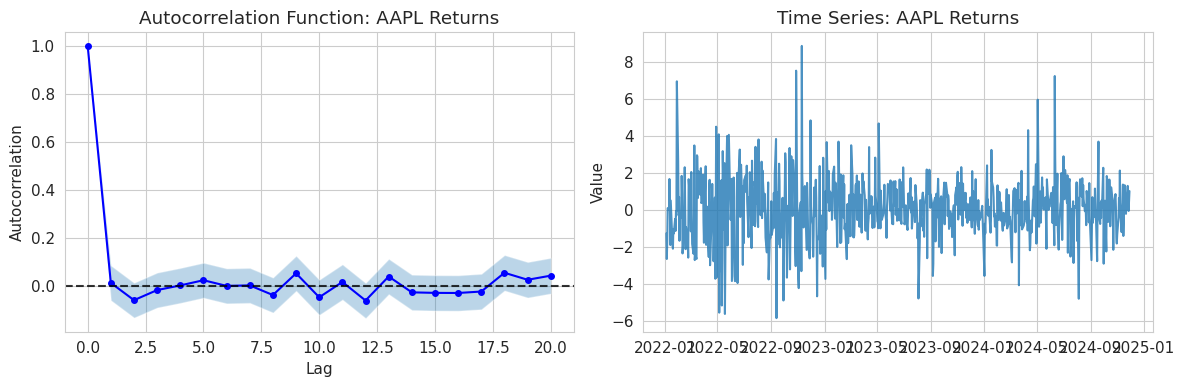


=== Autocorrelation Analysis: MSFT Returns ===
Ljung-Box test p-value (lag 10): 0.0247
-> Autocorrelation detected


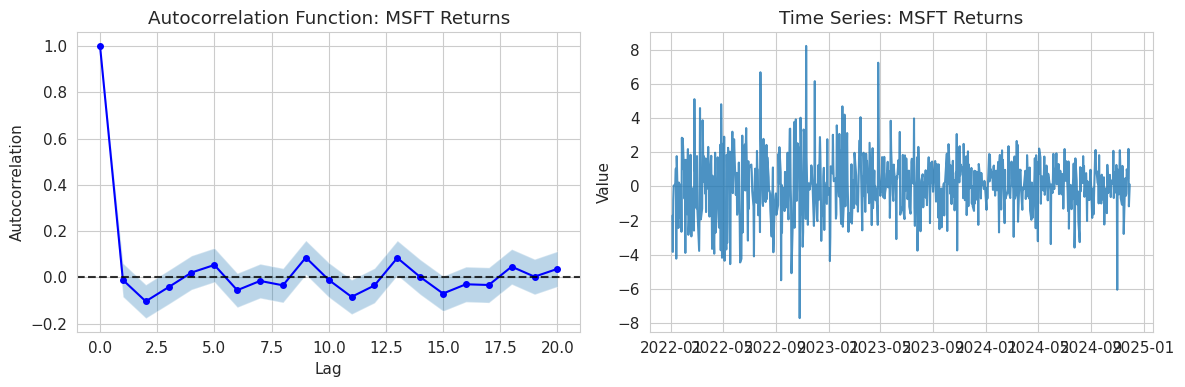

In [8]:
# check autocorrelation in returns
AAPL_has_autocorr = check_autocorrelation(returns['AAPL'], 'AAPL Returns')
MSFT_has_autocorr = check_autocorrelation(returns['MSFT'], 'MSFT Returns')

#3 Naive Comparison

In [9]:
def naive_comparison(series1, series2, name1, name2):
    """Standard Mann-Whitney U test ignoring temporal structure"""
    print(f"\n=== Naive Comparison: {name1} vs {name2} ===")

    # Mann-Whitney U test
    stat, p_value = mannwhitneyu(series1, series2, alternative='two-sided')

    # Basic statistics
    print(f"{name1}: Mean = {series1.mean():.3f}, Std = {series1.std():.3f}")
    print(f"{name2}: Mean = {series2.mean():.3f}, Std = {series2.std():.3f}")
    print(f"Mann-Whitney U statistic: {stat:.2f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Result: {'Significantly different' if p_value < 0.05 else 'Not significantly different'}")

    return p_value

In [10]:
naive_p = naive_comparison(returns['AAPL'], returns['MSFT'], 'AAPL Returns', 'MSFT Returns')


=== Naive Comparison: AAPL Returns vs MSFT Returns ===
AAPL Returns: Mean = 0.053, Std = 1.722
MSFT Returns: Mean = 0.051, Std = 1.750
Mann-Whitney U statistic: 266374.00
P-value: 0.920456
Result: Not significantly different


#4 Pre Whitening approach

In [11]:
def prewhiten_series(series, name):
    """Remove temporal correlation using ARIMA modeling"""
    print(f"\n=== Pre-whitening: {name} ===")

    # Fit ARIMA(1,0,0) model - simple AR(1)
    model = ARIMA(series, order=(1, 0, 0))
    fitted = model.fit()

    # Extract residuals
    residuals = fitted.resid

    print(f"AR(1) coefficient: {fitted.params[1]:.4f}")
    print(f"Residuals mean: {residuals.mean():.4f}")
    print(f"Residuals std: {residuals.std():.4f}")

    # Check if residuals are white noise
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_residuals = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(f"Ljung-Box test on residuals p-value: {lb_residuals['lb_pvalue'].iloc[-1]:.4f}")

    return residuals, fitted

In [12]:
AAPL_residuals, AAPL_model = prewhiten_series(returns['AAPL'], 'AAPL ')
MSFT_residuals, MSFT_model = prewhiten_series(returns['MSFT'], 'MSFT ')


=== Pre-whitening: AAPL  ===
AR(1) coefficient: 0.0135
Residuals mean: 0.0000
Residuals std: 1.7223
Ljung-Box test on residuals p-value: 0.6207

=== Pre-whitening: MSFT  ===
AR(1) coefficient: -0.0109
Residuals mean: -0.0000
Residuals std: 1.7497
Ljung-Box test on residuals p-value: 0.0252


In [13]:
# Compare pre-whitened series
def compare_prewhitened(resid1, resid2, name1, name2):
    """Compare pre-whitened residuals"""
    print(f"\n=== Pre-whitened Comparison: {name1} vs {name2} ===")

    stat, p_value = mannwhitneyu(resid1, resid2, alternative='two-sided')

    print(f"Mann-Whitney U statistic: {stat:.2f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Result: {'Significantly different' if p_value < 0.05 else 'Not significantly different'}")

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Time series of residuals
    axes[0].plot(resid1.index, resid1, label=name1, alpha=0.7)
    axes[0].plot(resid2.index, resid2, label=name2, alpha=0.7)
    axes[0].set_title('Pre-whitened Residuals')
    axes[0].set_ylabel('Residual')
    axes[0].legend()

    # Distribution comparison
    axes[1].hist(resid1, bins=30, alpha=0.7, label=name1, density=True)
    axes[1].hist(resid2, bins=30, alpha=0.7, label=name2, density=True)
    axes[1].set_title('Residual Distributions')
    axes[1].set_xlabel('Residual Value')
    axes[1].set_ylabel('Density')
    axes[1].legend()

    # Box plot
    box_data = pd.DataFrame({name1: resid1, name2: resid2})
    axes[2].boxplot([resid1.dropna(), resid2.dropna()], labels=[name1, name2])
    axes[2].set_title('Residual Box Plots')
    axes[2].set_ylabel('Residual Value')

    plt.tight_layout()
    plt.show()

    return p_value


=== Pre-whitened Comparison: AAPL vs MSFT ===
Mann-Whitney U statistic: 265982.00
P-value: 0.882007
Result: Not significantly different


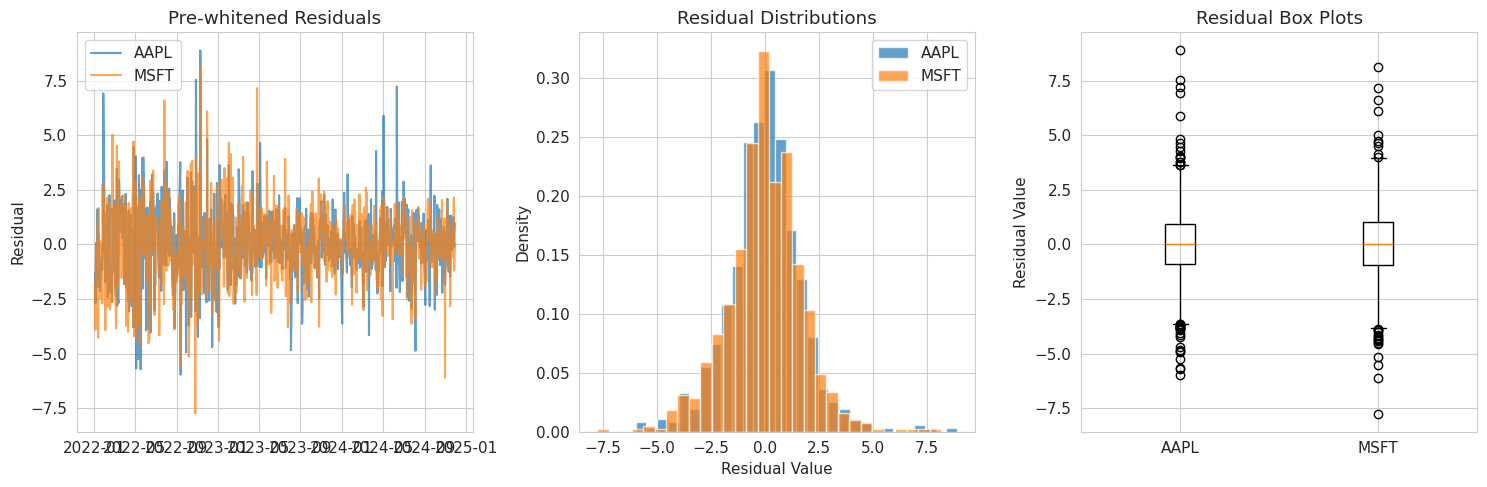

In [14]:
prewhitened_p = compare_prewhitened(AAPL_residuals, MSFT_residuals, 'AAPL', 'MSFT')

#5 Dynamic time warping DTW

In [15]:
def dtw_comparison(series1, series2, name1, name2):
    """Compare time series using Dynamic Time Warping"""
    print(f"\n=== DTW Analysis: {name1} vs {name2} ===")

    # Convert to numpy arrays and ensure they're clean
    s1 = series1.dropna().values
    s2 = series2.dropna().values

    # Truncate to same length for fair comparison
    min_len = min(len(s1), len(s2))
    s1 = s1[:min_len]
    s2 = s2[:min_len]

    print(f"Comparing series of length: {len(s1)}")

    # Calculate DTW distance
    dtw_distance = dtw.distance(s1, s2)
    print(f"DTW Distance: {dtw_distance:.4f}")

    # Get optimal warping path
    path = dtw.warping_path(s1, s2)

    # Create DTW visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Original time series
    axes[0,0].plot(range(len(s1)), s1, 'b-', label=name1, alpha=0.8)
    axes[0,0].plot(range(len(s2)), s2, 'r-', label=name2, alpha=0.8)
    axes[0,0].set_title('Original Time Series')
    axes[0,0].set_ylabel('Value')
    axes[0,0].legend()

    # DTW path visualization (simplified)
    # Create a manual distance matrix for visualization
    n1, n2 = len(s1), len(s2)
    dtw_matrix = np.zeros((n1, n2))

    for i in range(n1):
        for j in range(n2):
            dtw_matrix[i, j] = abs(s1[i] - s2[j])

    im = axes[0,1].imshow(dtw_matrix, cmap='viridis', aspect='auto')
    axes[0,1].plot([p[1] for p in path], [p[0] for p in path], 'w-', linewidth=2)
    axes[0,1].set_title('DTW Distance Matrix & Optimal Path')
    axes[0,1].set_xlabel(f'{name2} Index')
    axes[0,1].set_ylabel(f'{name1} Index')
    plt.colorbar(im, ax=axes[0,1])

    # Aligned series using DTW path
    aligned_s1 = [s1[p[0]] for p in path]
    aligned_s2 = [s2[p[1]] for p in path]

    axes[1,0].plot(aligned_s1, 'b-', label=f'{name1} (aligned)', alpha=0.8)
    axes[1,0].plot(aligned_s2, 'r-', label=f'{name2} (aligned)', alpha=0.8)
    axes[1,0].set_title('DTW Aligned Series')
    axes[1,0].set_ylabel('Value')
    axes[1,0].legend()

    # Scatter plot of aligned values
    axes[1,1].scatter(aligned_s1, aligned_s2, alpha=0.6)
    axes[1,1].plot([min(aligned_s1), max(aligned_s1)], [min(aligned_s1), max(aligned_s1)], 'r--')
    correlation_aligned = np.corrcoef(aligned_s1, aligned_s2)[0,1]
    axes[1,1].set_xlabel(f'{name1} (aligned)')
    axes[1,1].set_ylabel(f'{name2} (aligned)')
    axes[1,1].set_title(f'Aligned Values (r = {correlation_aligned:.3f})')

    plt.tight_layout()
    plt.show()

    return dtw_distance, aligned_s1, aligned_s2


=== DTW Analysis: AAPL vs MSFT ===
Comparing series of length: 731
DTW Distance: 28.5668


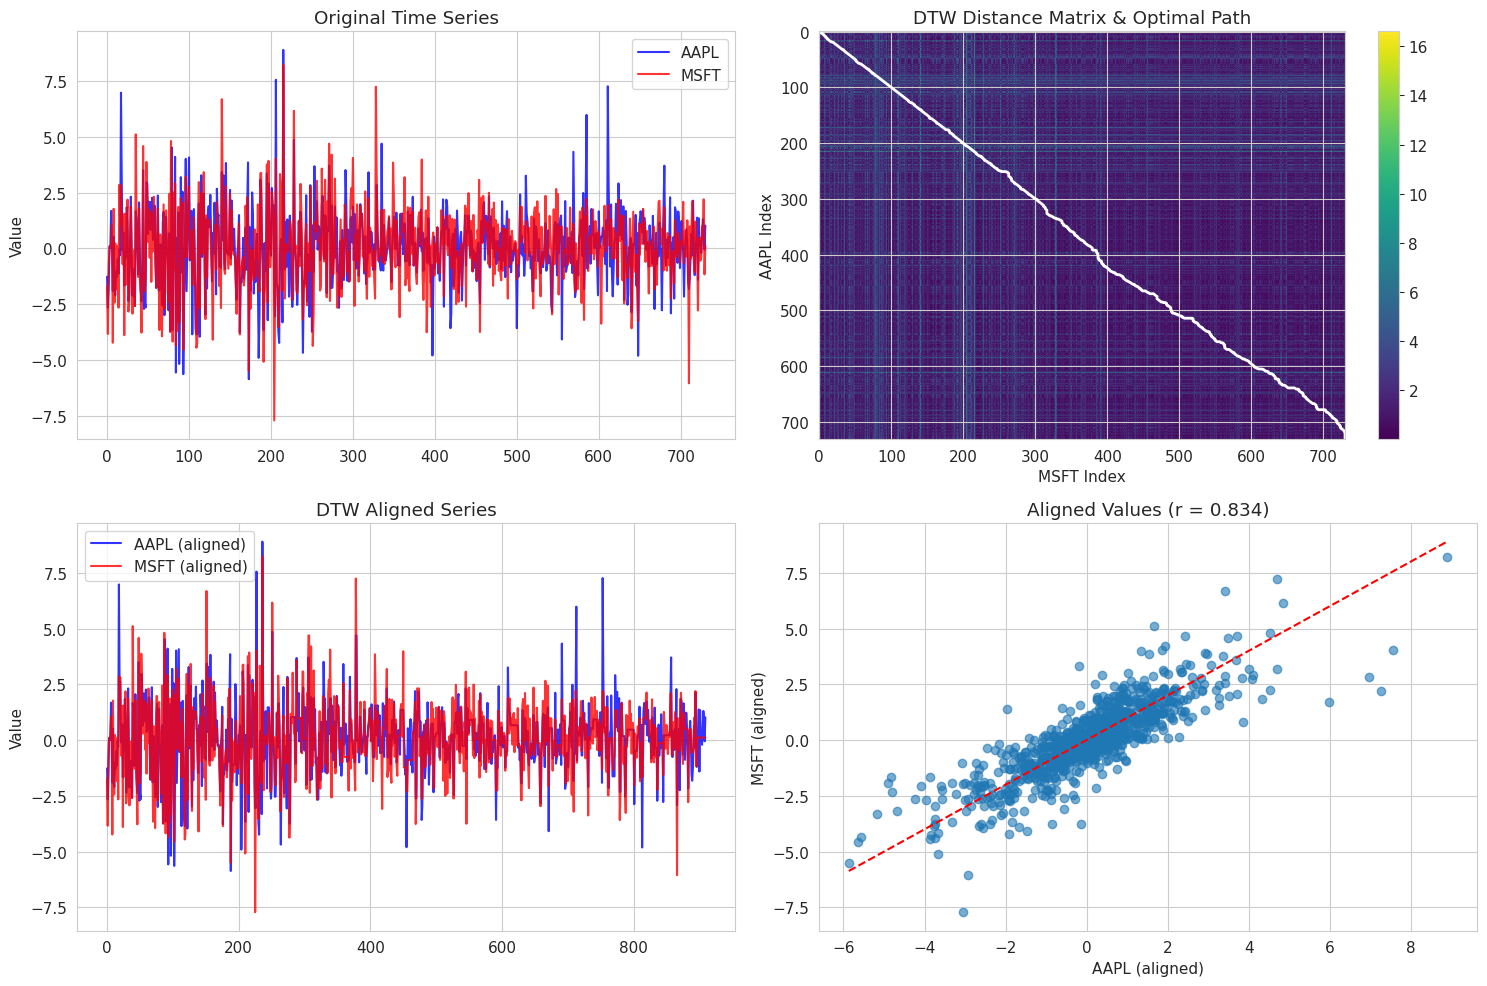

In [16]:
# Apply DTW to returns
dtw_dist, AAPL_aligned, MSFT_aligned = dtw_comparison(returns['AAPL'], returns['MSFT'], 'AAPL', 'MSFT')

In [17]:
def compare_dtw_aligned(aligned1, aligned2, name1, name2):
    """Compare DTW-aligned series"""
    print(f"\n=== DTW-Aligned Comparison: {name1} vs {name2} ===")

    stat, p_value = mannwhitneyu(aligned1, aligned2, alternative='two-sided')

    print(f"Mann-Whitney U statistic: {stat:.2f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Result: {'Significantly different' if p_value < 0.05 else 'Not significantly different'}")

    return p_value

In [18]:
dtw_aligned_p = compare_dtw_aligned(AAPL_aligned, MSFT_aligned, 'AAPL', 'MSFT')


=== DTW-Aligned Comparison: AAPL vs MSFT ===
Mann-Whitney U statistic: 419637.00
P-value: 0.618237
Result: Not significantly different


#6 block bootstrap

In [19]:
def block_bootstrap_test(series1, series2, name1, name2, block_size=10, n_bootstrap=1000):
    """Block bootstrap test preserving temporal correlation"""
    print(f"\n=== Block Bootstrap Test: {name1} vs {name2} ===")
    print(f"Block size: {block_size}, Bootstrap samples: {n_bootstrap}")

    # Original test statistic (difference in means)
    original_diff = series1.mean() - series2.mean()
    print(f"Original mean difference: {original_diff:.4f}")

    # Combine series for bootstrap
    combined = pd.concat([series1, series2])
    n1, n2 = len(series1), len(series2)
    n_total = len(combined)

    bootstrap_diffs = []

    for i in range(n_bootstrap):
        # Generate bootstrap sample using block sampling
        bootstrap_sample = []
        current_pos = 0

        while len(bootstrap_sample) < n_total:
            # Random starting position
            start = np.random.randint(0, n_total - block_size + 1)
            block = combined.iloc[start:start + block_size].values
            bootstrap_sample.extend(block)

        # Trim to exact size
        bootstrap_sample = bootstrap_sample[:n_total]

        # Split into two groups
        boot_group1 = bootstrap_sample[:n1]
        boot_group2 = bootstrap_sample[n1:n1+n2]

        # Calculate test statistic
        boot_diff = np.mean(boot_group1) - np.mean(boot_group2)
        bootstrap_diffs.append(boot_diff)

    bootstrap_diffs = np.array(bootstrap_diffs)

    # Calculate p-value (two-tailed)
    p_value = 2 * min(np.mean(bootstrap_diffs >= original_diff),
                      np.mean(bootstrap_diffs <= original_diff))

    print(f"Bootstrap p-value: {p_value:.4f}")
    print(f"Result: {'Significantly different' if p_value < 0.05 else 'Not significantly different'}")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.hist(bootstrap_diffs, bins=50, alpha=0.7, density=True, color='lightblue')
    plt.axvline(original_diff, color='red', linestyle='--', linewidth=2,
                label=f'Observed difference: {original_diff:.4f}')
    plt.axvline(0, color='black', linestyle='-', alpha=0.5, label='Null hypothesis')
    plt.xlabel('Mean Difference')
    plt.ylabel('Density')
    plt.title(f'Block Bootstrap Distribution (p = {p_value:.4f})')
    plt.legend()
    plt.show()

    return p_value


=== Block Bootstrap Test: AAPL vs MSFT ===
Block size: 10, Bootstrap samples: 1000
Original mean difference: 0.0024
Bootstrap p-value: 0.9000
Result: Not significantly different


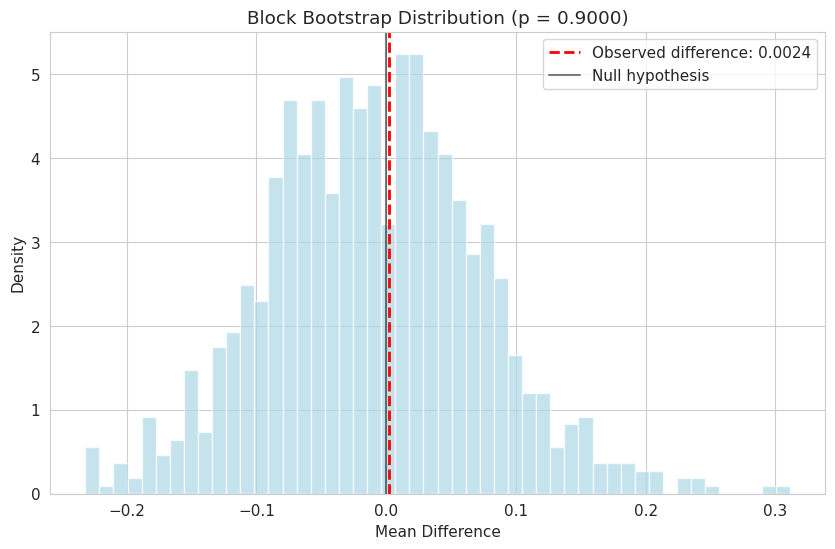

In [20]:
block_bootstrap_p = block_bootstrap_test(returns['AAPL'], returns['MSFT'], 'AAPL', 'MSFT')

#7 final comparison


SUMMARY OF ALL APPROACHES
                Method  P-value  Significant
  Naive Mann-Whitney U 0.920456        False
Pre-whitened Residuals 0.882007        False
           DTW Aligned 0.618237        False
       Block Bootstrap 0.900000        False

Key Insights:
- Temporal autocorrelation was detected
- DTW distance between series: 28.5668
- Original correlation: 0.685


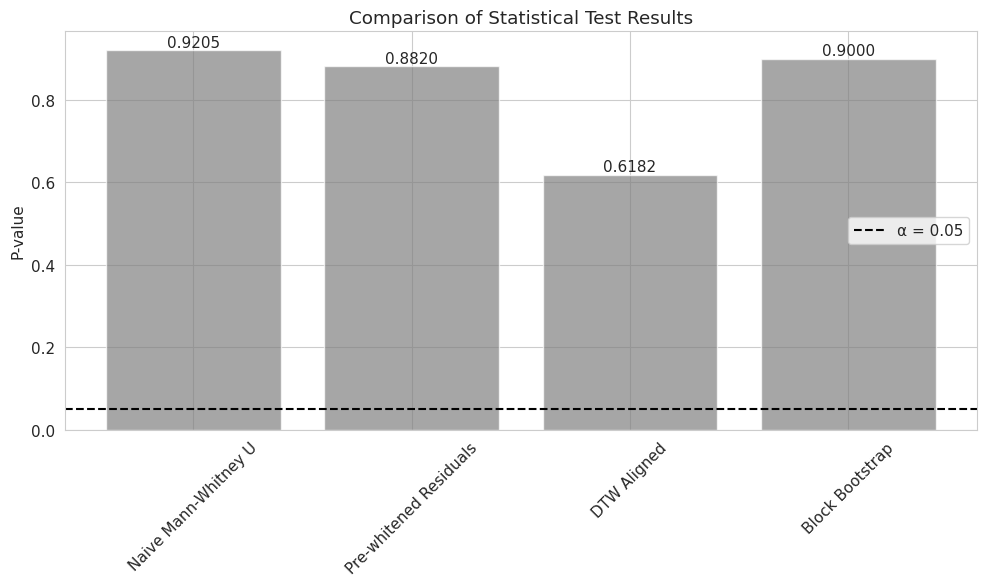

In [21]:
print("\n" + "="*60)
print("SUMMARY OF ALL APPROACHES")
print("="*60)

results_summary = pd.DataFrame({
    'Method': ['Naive Mann-Whitney U', 'Pre-whitened Residuals', 'DTW Aligned', 'Block Bootstrap'],
    'P-value': [naive_p, prewhitened_p, dtw_aligned_p, block_bootstrap_p],
    'Significant': [p < 0.05 for p in [naive_p, prewhitened_p, dtw_aligned_p, block_bootstrap_p]]
})

print(results_summary.to_string(index=False))

print(f"\nKey Insights:")
print(f"- Temporal autocorrelation {'was' if AAPL_has_autocorr or MSFT_has_autocorr else 'was not'} detected")
print(f"- DTW distance between series: {dtw_dist:.4f}")
print(f"- Original correlation: {correlation:.3f}")

# Final visualization comparing all approaches
fig, ax = plt.subplots(figsize=(10, 6))
methods = results_summary['Method']
p_values = results_summary['P-value']
colors = ['red' if sig else 'gray' for sig in results_summary['Significant']]

bars = ax.bar(methods, p_values, color=colors, alpha=0.7)
ax.axhline(0.05, color='black', linestyle='--', label='α = 0.05')
ax.set_ylabel('P-value')
ax.set_title('Comparison of Statistical Test Results')
ax.tick_params(axis='x', rotation=45)

# Add p-value labels on bars
for bar, p_val in zip(bars, p_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{p_val:.4f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()